<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras import regularizers
from keras import callbacks
from keras import initializers
from keras.layers import BatchNormalization

In [136]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [137]:
# x_train = x_train.reshape(60000, 784).astype('float32') / 255
# x_test = x_test.reshape(10000, 784).astype('float32') / 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Перемешаем тренировочные данные
# train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [138]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [139]:
w_init = initializers.glorot_normal()
b_init = initializers.Zeros()

In [140]:
model = tf.keras.Sequential()

drop_out = 0.25
lern_rat = 0.001
neurons = 256

model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(neurons * 1, activation='relu', kernel_initializer=w_init, bias_initializer=b_init)) #, kernel_regularizer=regularizers.l2(lern_rat)
model.add(BatchNormalization())
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(neurons * 2, activation='tanh'))
model.add(BatchNormalization())
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(neurons * 1, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(drop_out))

# model.add(layers.Dense(neurons * 2, activation='relu'))
# model.add(BatchNormalization())
# model.add(layers.Dropout(drop_out * 2))

model.add(layers.Dense(10, activation='softmax'))

In [141]:
model.compile(#optimizer='adam',
              # optimizer='adamax',
              optimizer='nadam',
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy']) # sparse_categorical_accuracy

1/1 [==============================] - 0s 113ms/step


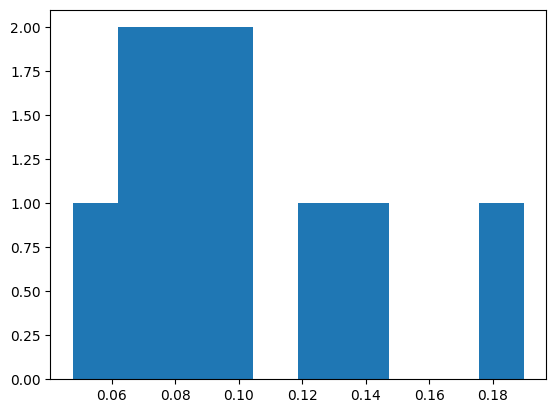

In [142]:
x = np.random.random((1, 28, 28))
a = model.predict(x)
_ = plt.hist(np.transpose(a))

In [143]:
y_pred = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [147]:
callback = callbacks.EarlyStopping(monitor='val_loss',
                                   patience=50,
                                   restore_best_weights=True,
                                   )
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = callbacks.ModelCheckpoint('best_model.h5', monitor='sparse_categorical_accuracy', mode='max', verbose=0, save_best_only=True)


In [148]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=128,
                    # callbacks=[callback],
                    callbacks=[es, mc],
                    verbose=1, #многословие
                    validation_data=(x_val, y_val))
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/100
391/391 [==============================] - 8s 19ms/step - loss: 0.3637 - sparse_categorical_accuracy: 0.8639 - val_loss: 0.3453 - val_sparse_categorical_accuracy: 0.8688
Epoch 2/100
391/391 [==============================] - 6s 16ms/step - loss: 0.3598 - sparse_categorical_accuracy: 0.8642 - val_loss: 0.3161 - val_sparse_categorical_accuracy: 0.8821
Epoch 3/100
391/391 [==============================] - 8s 21ms/step - loss: 0.3495 - sparse_categorical_accuracy: 0.8686 - val_loss: 0.3292 - val_sparse_categorical_accuracy: 0.8815
Epoch 4/100
391/391 [==============================] - 7s 17ms/step - loss: 0.3486 - sparse_categorical_accuracy: 0.8701 - val_loss: 0.3140 - val_sparse_categorical_accuracy: 0.8845
Epoch 5/100
391/391 [==============================] - 7s 19ms/step - loss: 0.3431 - sparse_categorical_accuracy: 0.8709 - val_loss: 0.3290 - val_sparse_categorical_accuracy: 0.8796
Epoch 6/100
391/391 [==============================] - 6s 16ms/step - loss: 0.3395 - spars

In [149]:
print('\nhistory dict:', list(history.history.keys()))


history dict: ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']


In [150]:
result = model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 1s 2ms/step - loss: 0.2969 - sparse_categorical_accuracy: 0.8976
[0.2968607544898987, 0.897599995136261]


In [151]:
# from keras.models import load_model
# saved_model = load_model('best_model.h5')
# # _, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
# _, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
# print('Test: %.3f' % (test_acc))

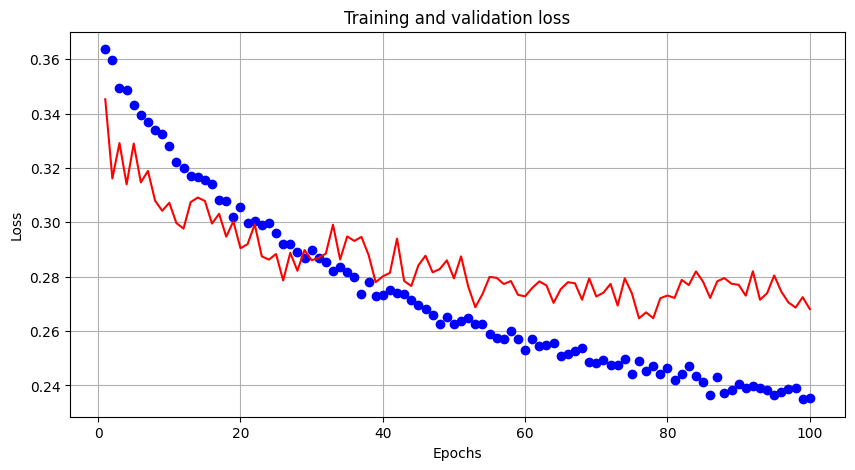

<Figure size 640x480 with 0 Axes>

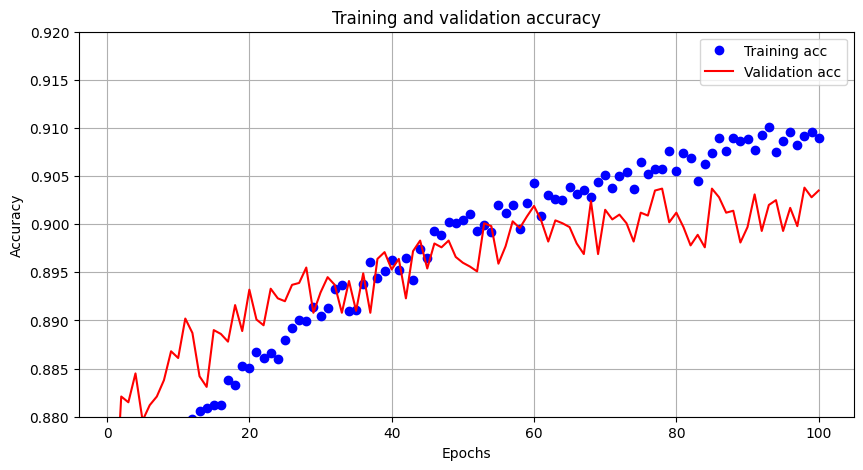

In [152]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend()
plt.grid(True)
plt.show()
1
plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['sparse_categorical_accuracy']
plt.plot(epochs, history_dict['sparse_categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_sparse_categorical_accuracy'], 'r', label='Validation acc')
plt.ylim (0.88, 0.92)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [153]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [154]:
predictions = probability_model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [155]:
predictions[0]

array([0.08537947, 0.08537947, 0.08537947, 0.08537947, 0.08537947,
       0.08538063, 0.08537947, 0.08567132, 0.08537947, 0.23129171],
      dtype=float32)

In [156]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dropout_28 (Dropout)        (None, 784)               0         
                                                                 
 dense_28 (Dense)            (None, 256)               200960    
                                                                 
 batch_normalization_21 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_29 (Dropout)        (None, 256)               0         
                                                                 
 dense_29 (Dense)            (None, 512)               131584    
                                                     